In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Data Preparation

In [2]:
df = pd.read_csv("/notebooks/Text-Multiclass-Classification/data_input/770 Whole Thread LabelledU.csv", index_col=0)
df = df[['clean_text', 'Dominant Label']]
df.head()

,clean_text,Dominant Label
Count,,
0,module transfer module leader module copy co...,VLE and Module
1,compromise manatee might send add...,Unclassifiable
2,reassign setup rove mikes room lib opsbusadm...,Hardware and Room
3,conference facilities room next wednesday b...,Hardware and Room
4,room seem lack function mfd room scan usb ...,Hardware and Room


### Remove row labeled : ['unclassifiable', 'None', and 'Network and database']

In [3]:
df["Dominant Label"].value_counts()

Software and Access     271
VLE and Module          204
Hardware and Room       150
Mail                     47
Account and Password     40
Unclassifiable           30
Network and Database     25
None                      2
Name: Dominant Label, dtype: int64

In [4]:
unclassifiable_mask = (df['Dominant Label'] != 'Unclassifiable')
none_mask = (df['Dominant Label'] != 'None')
network_database_mask = (df['Dominant Label'] != 'Network and Database')

In [5]:
df = df[unclassifiable_mask & none_mask & network_database_mask]
df['Dominant Label'].value_counts()

Software and Access     271
VLE and Module          204
Hardware and Room       150
Mail                     47
Account and Password     40
Name: Dominant Label, dtype: int64

In [6]:
label = df['Dominant Label'].unique()

In [7]:
# Encode the Dominant Label to integer value

df['Dominant Label'] = df['Dominant Label'].map({'VLE and Module' : 0,
                                                 'Hardware and Room' : 1,
                                                 'Mail' : 2,
                                                 'Software and Access' : 3,
                                                 'Account and Password' : 4 })                                         

# it's oke if we got Warning after running this code

### Handle Missing and Duplicate data

In [8]:
# Detect missing values
# isna() will check column if there is Nan, null, or na data it will return True  if not then False
# Since True = 1 and False = 0. when we sum together each True and False then we will know how many missing values is
df.isna().sum()

clean_text        0
Dominant Label    0
dtype: int64

In [9]:
True + True + True

3

In [10]:
# Detect Duplicate data

df[df.duplicated(keep = False)]

# df.duplicated when we set keep = False : Mark all duplicates as True.

,clean_text,Dominant Label
Count,,
91,add mail address brl mail list colleague add...,2
95,add mail address brl mail list colleague add...,2
102,add mail address brl mail list colleague add...,2


In [11]:
# Remove the duplicates data
df = df.drop_duplicates()

In [12]:
df

,clean_text,Dominant Label
Count,,
0,module transfer module leader module copy co...,0
2,reassign setup rove mikes room lib opsbusadm...,1
3,conference facilities room next wednesday b...,1
4,room seem lack function mfd room scan usb ...,1
5,phone frustrate polycom phone sign skype wont...,1
...,...,...
764,authenticator failure sign anything microso...,2
765,password password way reset apparently reg...,1
766,phone line student support line support phon...,3


In [13]:
X, y = df['clean_text'], df['Dominant Label']

### Train Test Split



In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.15)

### Preprocessing Data

NLTK vs Tensorflow

NLTK : usually we need to below step :<br>
    1. Case Folding <br>
    2. Tokenization <br>
    3. Stop words removal <br>
    4. Digit Removal <br>
    5. Punctuation Removal <br>
    6. Non ASCII-Removal <br>
    7. Vectorizing
    
when we come to Tensorflow, we just need to do :<br>
    1. stop words removal (optional)<br>
    2. Tokenization <br>
    3. Vectorizing (texts to sequence)<br>
    why there is no preprocesing? because Tokenization will include to handle the Case Folding, Digit Removal, Punctuation and Non ASCII


#### Tokenizer

In [15]:
# num_words = 2000, mean Tokenizer will take the top 2000 words by volume 
# usually minimum num_words will give  huge training time and less training acc 

# num_words = 2000

# currently im not define the num_words, so it will take all words on all the training text.
# uncomment the num_words = 2000, then pass it to Tokenizer(num_words = num_words, oov_token = oov_token) if you want define the num_words

#oov_token = "<OOV>" mean Out Of Vocabulary, since the test data is getting token by fitted train data then there is probability, 
#the word in test data is not recognize by the tokenizer then tokenizer will encode it as <OOV>
oov_token = "<OOV>"

tokenizer = Tokenizer(oov_token=oov_token)

# Generate the word index dictionary
tokenizer.fit_on_texts(X_train)

💡 Don't Forget to input num_words inside Tokenizer(num_words = num_words, oov_token = oov_token). if you uncomment the num_words = 2000

In [16]:
word_index = tokenizer.word_index
for v,k in word_index.items():
    print("{} : {}".format(v,k))
    if (k == 20):
        break

<OOV> : 1
open : 2
log : 3
access : 4
module : 5
assign : 6
phone : 7
reassign : 8
laptop : 9
blackboard : 10
team : 11
days : 12
progress : 13
student : 14
without : 15
say : 16
think : 17
view : 18
portal : 19
room : 20


In [17]:
# even we are not define the num_words before define the tokenizer class. we still need num_words value to pass it inisde Embedding layers later.
num_words = len(word_index)

💡 comment num_words above if you define the num_words and pass it inside Tokenizer(num_words = num_words, oov_token = oov_token)

#### Padding to make the data as 1 uniform before feed to the model

In [18]:
# if maxlen not defined then all the texts will padded to the max length of word in all the texts
# if the length of word in a text < maxlen we define then it will padding
# if the length of word in a text > maxlen we define then it will truncating

# example,
# text1 = "I buy"
# text2 = "I buy Orange" 
# let say we note define maxlen
# and the padding_type = post 

# since text 2 have the 3 word and text1 just have 2 word then it will padded to 3 
# word index = {'<OOV>' : 1, 'i' : 2, 'buy' : 3, 'orange' : 4}
# the the sequence will be 
# text1 = [2, 3, 0]
# text2 = [2, 3, 4]

max_length = 150
padding_type = "post"
trunc_type = "post"

# Generate and pad the training sequences
X_train = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train, maxlen= max_length,padding=padding_type, truncating=trunc_type)

# Generate and pad the testing sequences
X_test = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test, maxlen = max_length, padding=padding_type, truncating = trunc_type)

# Convert the labels lists into numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

## Modeling

### Simple Embedding

In [44]:
embedding_dim = 32
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words, embedding_dim, input_length = max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

# Print the model summary
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 150, 32)           148704    
                                                                 
 flatten_2 (Flatten)         (None, 4800)              0         
                                                                 
 dense_12 (Dense)            (None, 64)                307264    
                                                                 
 dense_13 (Dense)            (None, 5)                 325       
                                                                 
Total params: 456,293
Trainable params: 456,293
Non-trainable params: 0
_________________________________________________________________


In [31]:
# Compile the modeld
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [32]:
num_epochs = 60

# Train the model
history = model.fit(X_train_padded, y_train, epochs=num_epochs, validation_data=(X_test_padded, y_test))
%time

Epoch 1/60
19/19 [==============================] - 1s 14ms/step - loss: 1.5638 - accuracy: 0.2968 - val_loss: 1.4615 - val_accuracy: 0.3271
Epoch 2/60
19/19 [==============================] - 0s 5ms/step - loss: 1.2975 - accuracy: 0.6119 - val_loss: 1.3112 - val_accuracy: 0.4860
Epoch 3/60
19/19 [==============================] - 0s 6ms/step - loss: 0.9450 - accuracy: 0.7562 - val_loss: 1.1484 - val_accuracy: 0.5327
Epoch 4/60
19/19 [==============================] - 0s 5ms/step - loss: 0.5586 - accuracy: 0.8408 - val_loss: 1.0411 - val_accuracy: 0.6168
Epoch 5/60
19/19 [==============================] - 0s 6ms/step - loss: 0.2769 - accuracy: 0.9453 - val_loss: 1.0106 - val_accuracy: 0.6075
Epoch 6/60
19/19 [==============================] - 0s 6ms/step - loss: 0.1400 - accuracy: 0.9900 - val_loss: 0.9782 - val_accuracy: 0.6449
Epoch 7/60
19/19 [==============================] - 0s 5ms/step - loss: 0.0686 - accuracy: 0.9967 - val_loss: 0.9667 - val_accuracy: 0.6355
Epoch 8/60
19/19 [=

#### Evaluation

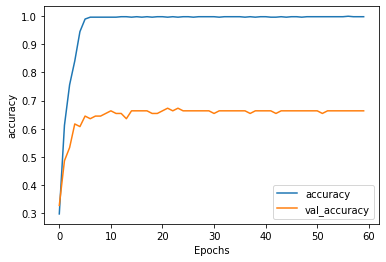

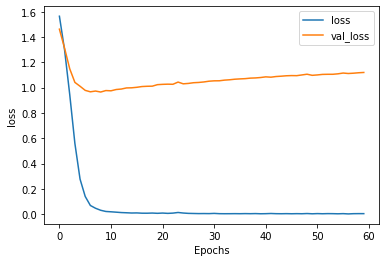

In [33]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [36]:
y_pred = model.predict(X_test_padded)
y_pred = np.argmax(y_pred,axis=1)
print(classification_report(y_test, y_pred, target_names= label))

4/4 [==============================] - 0s 2ms/step
                      precision    recall  f1-score   support

      VLE and Module       0.56      0.67      0.61        27
   Hardware and Room       0.86      0.78      0.82        23
                Mail       0.00      0.00      0.00         6
 Software and Access       0.63      0.71      0.67        45
Account and Password       1.00      0.50      0.67         6

            accuracy                           0.66       107
           macro avg       0.61      0.53      0.55       107
        weighted avg       0.65      0.66      0.65       107



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Embedding -> Conv1D

In [37]:
embedding_dim = 32
num_of_filters = 128
kernel_size = 5
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words, embedding_dim, input_length = max_length),
    tf.keras.layers.Conv1D(num_of_filters, kernel_size),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

# Print the model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 150, 32)           148704    
                                                                 
 conv1d_1 (Conv1D)           (None, 146, 128)          20608     
                                                                 
 flatten_1 (Flatten)         (None, 18688)             0         
                                                                 
 dense_8 (Dense)             (None, 64)                1196096   
                                                                 
 dense_9 (Dense)             (None, 5)                 325       
                                                                 
Total params: 1,365,733
Trainable params: 1,365,733
Non-trainable params: 0
_________________________________________________________________


In [38]:
# Compile the modeld
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [39]:
num_epochs = 60

# Train the model
history = model.fit(X_train_padded, y_train, epochs=num_epochs, validation_data=(X_test_padded, y_test))
%time

Epoch 1/60
19/19 [==============================] - 1s 16ms/step - loss: 1.4591 - accuracy: 0.3648 - val_loss: 1.3772 - val_accuracy: 0.4393
Epoch 2/60
19/19 [==============================] - 0s 7ms/step - loss: 1.0044 - accuracy: 0.6716 - val_loss: 1.1262 - val_accuracy: 0.6355
Epoch 3/60
19/19 [==============================] - 0s 7ms/step - loss: 0.4744 - accuracy: 0.8607 - val_loss: 1.0981 - val_accuracy: 0.5981
Epoch 4/60
19/19 [==============================] - 0s 8ms/step - loss: 0.1562 - accuracy: 0.9735 - val_loss: 1.0779 - val_accuracy: 0.6449
Epoch 5/60
19/19 [==============================] - 0s 7ms/step - loss: 0.0626 - accuracy: 0.9934 - val_loss: 1.1253 - val_accuracy: 0.6449
Epoch 6/60
19/19 [==============================] - 0s 8ms/step - loss: 0.0254 - accuracy: 0.9983 - val_loss: 1.1624 - val_accuracy: 0.6542
Epoch 7/60
19/19 [==============================] - 0s 7ms/step - loss: 0.0182 - accuracy: 0.9983 - val_loss: 1.2203 - val_accuracy: 0.6542
Epoch 8/60
19/19 [=

#### Evaluation

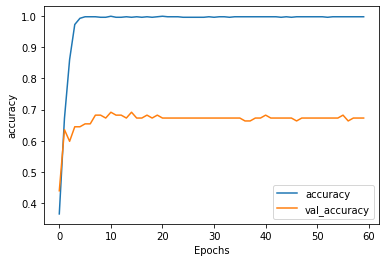

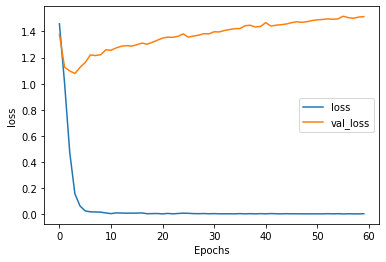

In [40]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [41]:
y_pred = model.predict(X_test_padded)
y_pred = np.argmax(y_pred,axis=1)
print(classification_report(y_test, y_pred, target_names= label))

4/4 [==============================] - 0s 3ms/step
                      precision    recall  f1-score   support

      VLE and Module       0.55      0.63      0.59        27
   Hardware and Room       0.69      0.78      0.73        23
                Mail       1.00      0.33      0.50         6
 Software and Access       0.71      0.71      0.71        45
Account and Password       1.00      0.50      0.67         6

            accuracy                           0.67       107
           macro avg       0.79      0.59      0.64       107
        weighted avg       0.70      0.67      0.67       107



### Embedding -> LSTM 

#### Evaluation

In [42]:
embedding_dim = 32
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words, embedding_dim, input_length = max_length),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

# Print the model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 150, 32)           148704    
                                                                 
 lstm_1 (LSTM)               (None, 64)                24832     
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 5)                 325       
                                                                 
Total params: 178,021
Trainable params: 178,021
Non-trainable params: 0
_________________________________________________________________


In [43]:
# Compile the modeld
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

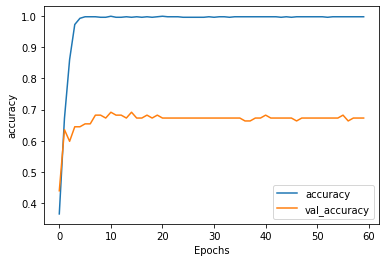

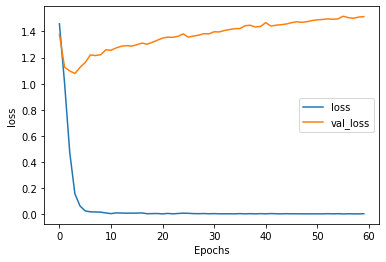

In [45]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [46]:
y_pred = model.predict(X_test_padded)
y_pred = np.argmax(y_pred,axis=1)
print(classification_report(y_test, y_pred, target_names= label))

4/4 [==============================] - 0s 3ms/step
                      precision    recall  f1-score   support

      VLE and Module       0.20      0.04      0.06        27
   Hardware and Room       0.00      0.00      0.00        23
                Mail       0.00      0.00      0.00         6
 Software and Access       0.29      0.13      0.18        45
Account and Password       0.04      0.33      0.08         6

            accuracy                           0.08       107
           macro avg       0.11      0.10      0.06       107
        weighted avg       0.17      0.08      0.10       107



### Embedding -> Bidirectional LSTM

In [47]:
embedding_dim = 32
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words, embedding_dim, input_length = max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

# Print the model summary
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 150, 32)           148704    
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              49664     
 nal)                                                            
                                                                 
 dense_14 (Dense)            (None, 64)                8256      
                                                                 
 dense_15 (Dense)            (None, 5)                 325       
                                                                 
Total params: 206,949
Trainable params: 206,949
Non-trainable params: 0
_________________________________________________________________


In [48]:
# Compile the modeld
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [49]:
num_epochs = 60

# Train the model
history = model.fit(X_train_padded, y_train, epochs=num_epochs, validation_data=(X_test_padded, y_test))
%time

Epoch 1/60
19/19 [==============================] - 6s 98ms/step - loss: 1.5324 - accuracy: 0.3416 - val_loss: 1.3886 - val_accuracy: 0.4206
Epoch 2/60
19/19 [==============================] - 1s 28ms/step - loss: 1.3963 - accuracy: 0.3731 - val_loss: 1.3380 - val_accuracy: 0.4206
Epoch 3/60
19/19 [==============================] - 1s 29ms/step - loss: 1.3024 - accuracy: 0.4129 - val_loss: 1.2197 - val_accuracy: 0.4393
Epoch 4/60
19/19 [==============================] - 1s 28ms/step - loss: 1.1561 - accuracy: 0.4959 - val_loss: 1.2017 - val_accuracy: 0.5701
Epoch 5/60
19/19 [==============================] - 1s 27ms/step - loss: 1.0425 - accuracy: 0.6186 - val_loss: 1.0282 - val_accuracy: 0.6075
Epoch 6/60
19/19 [==============================] - 1s 27ms/step - loss: 0.8081 - accuracy: 0.7463 - val_loss: 0.9490 - val_accuracy: 0.6262
Epoch 7/60
19/19 [==============================] - 1s 29ms/step - loss: 0.6361 - accuracy: 0.7844 - val_loss: 0.9560 - val_accuracy: 0.6449
Epoch 8/60
19

#### Evaluation

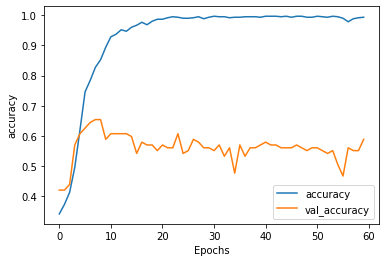

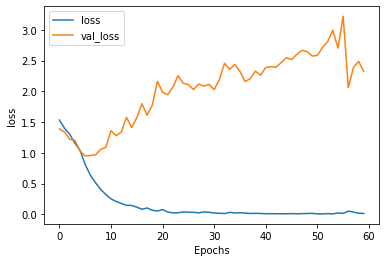

In [50]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [51]:
y_pred = model.predict(X_test_padded)
y_pred = np.argmax(y_pred,axis=1)
print(classification_report(y_test, y_pred, target_names= label))

4/4 [==============================] - 1s 11ms/step
                      precision    recall  f1-score   support

      VLE and Module       0.62      0.56      0.59        27
   Hardware and Room       0.52      0.57      0.54        23
                Mail       1.00      0.17      0.29         6
 Software and Access       0.67      0.69      0.68        45
Account and Password       0.27      0.50      0.35         6

            accuracy                           0.59       107
           macro avg       0.62      0.50      0.49       107
        weighted avg       0.62      0.59      0.59       107



### Embeding -> Stacked Bidirectional

In [52]:
embedding_dim = 32
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words, embedding_dim, input_length = max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

# Print the model summary
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 150, 32)           148704    
                                                                 
 bidirectional_2 (Bidirectio  (None, 150, 128)         49664     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dense_17 (Dense)            (None, 5)                 325       
                                                                 
Total params: 305,765
Trainable params: 305,765
Non-tr

In [53]:
# Compile the modeld
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [54]:
num_epochs = 60

# Train the model
history = model.fit(X_train_padded, y_train, epochs=num_epochs, validation_data=(X_test_padded, y_test))
%time

Epoch 1/60
19/19 [==============================] - 12s 170ms/step - loss: 1.5259 - accuracy: 0.3267 - val_loss: 1.4079 - val_accuracy: 0.2617
Epoch 2/60
19/19 [==============================] - 1s 50ms/step - loss: 1.4000 - accuracy: 0.3897 - val_loss: 1.3359 - val_accuracy: 0.4206
Epoch 3/60
19/19 [==============================] - 1s 53ms/step - loss: 1.2576 - accuracy: 0.4345 - val_loss: 1.0355 - val_accuracy: 0.5327
Epoch 4/60
19/19 [==============================] - 1s 51ms/step - loss: 0.8984 - accuracy: 0.6683 - val_loss: 1.0060 - val_accuracy: 0.6262
Epoch 5/60
19/19 [==============================] - 1s 52ms/step - loss: 0.7215 - accuracy: 0.7512 - val_loss: 1.0946 - val_accuracy: 0.5140
Epoch 6/60
19/19 [==============================] - 1s 51ms/step - loss: 0.5111 - accuracy: 0.8176 - val_loss: 1.0407 - val_accuracy: 0.5888
Epoch 7/60
19/19 [==============================] - 1s 52ms/step - loss: 0.3447 - accuracy: 0.8673 - val_loss: 1.3316 - val_accuracy: 0.6075
Epoch 8/60


#### Evaluation

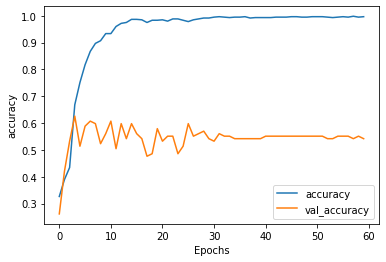

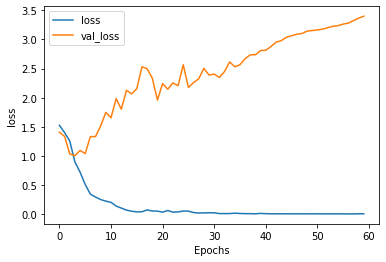

In [55]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [56]:
y_pred = model.predict(X_test_padded)
y_pred = np.argmax(y_pred,axis=1)
print(classification_report(y_test, y_pred, target_names= label))

4/4 [==============================] - 2s 18ms/step
                      precision    recall  f1-score   support

      VLE and Module       0.44      0.52      0.47        27
   Hardware and Room       0.56      0.61      0.58        23
                Mail       0.50      0.17      0.25         6
 Software and Access       0.63      0.58      0.60        45
Account and Password       0.43      0.50      0.46         6

            accuracy                           0.54       107
           macro avg       0.51      0.47      0.47       107
        weighted avg       0.55      0.54      0.54       107



### Embedding -> Conv1d -> stacked Bidirectional LSTM 

In [58]:
embedding_dim = 32
num_of_filters = 128
kernel_size = 5
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words, embedding_dim, input_length = max_length),
    tf.keras.layers.Conv1D(num_of_filters, kernel_size),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

# Print the model summary
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 150, 32)           148704    
                                                                 
 conv1d_2 (Conv1D)           (None, 146, 128)          20608     
                                                                 
 bidirectional_4 (Bidirectio  (None, 146, 128)         98816     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                                 
 dense_19 (Dense)            (None, 5)                

In [60]:
# Compile the modeld
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [61]:
num_epochs = 60

# Train the model
history = model.fit(X_train_padded, y_train, epochs=num_epochs, validation_data=(X_test_padded, y_test))
%time

Epoch 1/60
19/19 [==============================] - 13s 214ms/step - loss: 1.5105 - accuracy: 0.2952 - val_loss: 1.3631 - val_accuracy: 0.4206
Epoch 2/60
19/19 [==============================] - 1s 52ms/step - loss: 1.3534 - accuracy: 0.3947 - val_loss: 1.2570 - val_accuracy: 0.2897
Epoch 3/60
19/19 [==============================] - 1s 53ms/step - loss: 1.0855 - accuracy: 0.5572 - val_loss: 0.9444 - val_accuracy: 0.6355
Epoch 4/60
19/19 [==============================] - 1s 52ms/step - loss: 0.8606 - accuracy: 0.6915 - val_loss: 0.9867 - val_accuracy: 0.6075
Epoch 5/60
19/19 [==============================] - 1s 54ms/step - loss: 0.6553 - accuracy: 0.7828 - val_loss: 1.1143 - val_accuracy: 0.5607
Epoch 6/60
19/19 [==============================] - 1s 52ms/step - loss: 0.4798 - accuracy: 0.8458 - val_loss: 1.2411 - val_accuracy: 0.5701
Epoch 7/60
19/19 [==============================] - 1s 53ms/step - loss: 0.3198 - accuracy: 0.8905 - val_loss: 1.2839 - val_accuracy: 0.5888
Epoch 8/60


#### Evaluation

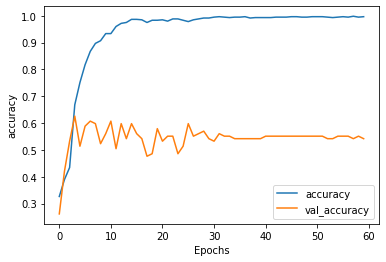

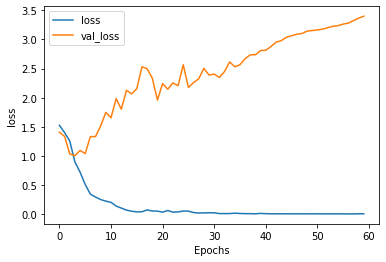

In [59]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")